In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('display.max_rows', None)

In [2]:
#data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'
#!wget $data

df = pd.read_csv('course_lead_scoring.csv')
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


### Data Prep

In [3]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [49]:
categorical = ['lead_source', 'industry', 'employment_status', 'location'] 
numerical = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']

In [5]:
for i in categorical:
    df[i] = df[i].fillna('NA')

for i in numerical:
    df[i] = df[i].fillna(0.0)

In [6]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

#### Questão 1:
##### R: retail

In [7]:
df['industry'].mode()

0    retail
Name: industry, dtype: object

In [8]:
df['industry'].value_counts().sort_values(ascending=False).head(1)

industry
retail    203
Name: count, dtype: int64

#### Questão 2:
##### R: number_of_courses_viewed and interaction_count
##### Checar na entrega


In [9]:
df[numerical].corr()

,number_of_courses_viewed,annual_income,interaction_count,lead_score
number_of_courses_viewed,1.000000,0.009770,-0.023565,-0.004879
annual_income,0.009770,1.000000,0.027036,0.015610
interaction_count,-0.023565,0.027036,1.000000,0.009888
lead_score,-0.004879,0.015610,0.009888,1.000000


<Axes: >

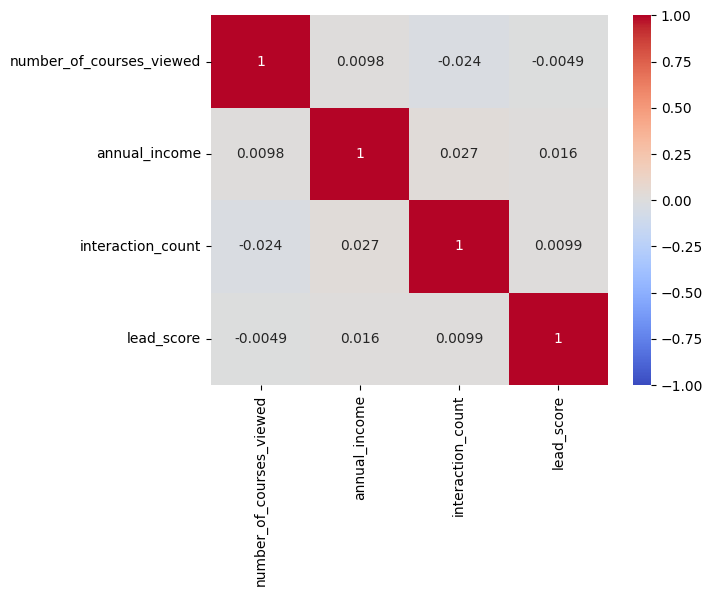

In [10]:
sns.heatmap(df[numerical].corr(), annot=True, vmin=-1, vmax=1, cmap='coolwarm')
# Maior é 0.027 > interaction_count x annual_income

# interaction_count and lead_score >> 0.010
# number_of_courses_viewed and lead_score >> -0.005
# number_of_courses_viewed and interaction_count >> 0.024
# annual_income and lead_score >> 0.016

#### Questão 3:
##### R: lead_source

In [11]:
# Splitando os dados

from sklearn.model_selection import train_test_split

In [12]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)
len(df_full_train), len(df_train), len(df_test), len(df_val)

(1169, 876, 293, 293)

In [13]:
# Resetamos os indíces dos DFs apenas para não ficar embaralhado

df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [14]:
y_full_train = df_full_train['converted'].values
y_train = df_train['converted'].values
y_val = df_val['converted'].values
y_test = df_test['converted'].values

In [15]:
del df_full_train['converted']
del df_train['converted']
del df_val['converted']
del df_test['converted']

In [16]:
# Mutual information

from sklearn.metrics import mutual_info_score

In [17]:
mutual = {}
for i in categorical:
    a = round(mutual_info_score(y_train,df_train[i]),2)
    mutual[i] = a
df_mutual = pd.DataFrame(list(mutual.items()), columns=['feature', 'mutual_info (%)'])
df_mutual = df_mutual.sort_values(by="mutual_info (%)", ascending=False).reset_index(drop=True)
df_mutual

,feature,mutual_info (%)
0,lead_source,0.04
1,industry,0.01
2,employment_status,0.01
3,location,0.00


#### Questão 4:
##### R:    (verificar o valor de corte)

In [18]:
from sklearn.feature_extraction import DictVectorizer

In [19]:
train_dicts = df_train[categorical + numerical].to_dict(orient='records')
val_dicts = df_val[categorical + numerical].to_dict(orient='records')

In [20]:
dv = DictVectorizer(sparse=False)

In [21]:
dv.fit(train_dicts)
list(dv.get_feature_names_out())

['annual_income',
 'employment_status=NA',
 'employment_status=employed',
 'employment_status=self_employed',
 'employment_status=student',
 'employment_status=unemployed',
 'industry=NA',
 'industry=education',
 'industry=finance',
 'industry=healthcare',
 'industry=manufacturing',
 'industry=other',
 'industry=retail',
 'industry=technology',
 'interaction_count',
 'lead_score',
 'lead_source=NA',
 'lead_source=events',
 'lead_source=organic_search',
 'lead_source=paid_ads',
 'lead_source=referral',
 'lead_source=social_media',
 'location=NA',
 'location=africa',
 'location=asia',
 'location=australia',
 'location=europe',
 'location=middle_east',
 'location=north_america',
 'location=south_america',
 'number_of_courses_viewed']

In [22]:
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [23]:
X_train.shape, X_val.shape

((876, 31), (293, 31))

In [24]:
from sklearn.linear_model import LogisticRegression

In [25]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [26]:
model.intercept_[0]

np.float64(-0.0691472802783609)

In [27]:
model.coef_[0].round(3)

array([-0.   , -0.015,  0.034,  0.003,  0.012, -0.103, -0.025,  0.049,
       -0.02 , -0.013, -0.003, -0.009, -0.032, -0.016,  0.311,  0.051,
        0.02 , -0.012, -0.012, -0.115,  0.08 , -0.03 ,  0.004, -0.011,
       -0.011, -0.006,  0.008,  0.006, -0.033, -0.025,  0.454])

In [58]:
y_pred = model.predict_proba(X_val)[:,1]
converted = (y_pred >= 0.6)
acc_original = (y_val == converted).mean() #accuracy
acc_original

np.float64(0.7781569965870307)

#### Questão 5:
##### R: industry

In [ ]:
def logistic_reg_train(df_train, df_val, categorical, numerical, t, drop):
    
    use = categorical.copy()
    use.remove(drop)

    print(use)

    train_dicts = df_train[use + numerical].to_dict(orient='records')
    val_dicts = df_val[use + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)

    dv.fit(train_dicts)

    X_train = dv.fit_transform(train_dicts)
    X_val = dv.transform(val_dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_val)[:,1]
    converted = (y_pred >= t)
    x = ((y_val == converted).mean()) #accuracy

    return x

In [65]:
drops_col = ['industry', 'employment_status', 'lead_source']

for i in drops_col:
    acc = logistic_reg_train(df_train, df_val, categorical, numerical, t=0.6, drop=i)
    diff = (acc_original - acc).round(5)
    print(f"Dropando a coluna {i}, a acurácia foi de {acc.round(4)}. A diferença foi de {diff}.")

['lead_source', 'employment_status', 'location']
Dropando a coluna industry, a acurácia foi de 0.7782. A diferença foi de -4e-05.
['lead_source', 'industry', 'location']
Dropando a coluna employment_status, a acurácia foi de 0.7816. A diferença foi de -0.00344.
['industry', 'employment_status', 'location']
Dropando a coluna lead_source, a acurácia foi de 0.7816. A diferença foi de -0.00344.


#### Questão 6:
##### R: C = 0.1

In [66]:
def logistic_reg_train(df_train, df_val, categorical, numerical, t, c):
    
    train_dicts = df_train[categorical + numerical].to_dict(orient='records')
    val_dicts = df_val[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)

    dv.fit(train_dicts)

    X_train = dv.fit_transform(train_dicts)
    X_val = dv.transform(val_dicts)

    model = LogisticRegression(solver='liblinear', C=c, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_val)[:,1]
    converted = (y_pred >= t)
    x = ((y_val == converted).mean()) #accuracy

    return x

In [71]:
c_values = [0.01, 0.1, 1, 10, 100]


for i in c_values:
    acc = logistic_reg_train(df_train, df_val, categorical, numerical, t=0.6, c=i)
    print(f"Utilizando C = {i} a acurácia foi de {acc.round(4)}")

Utilizando C = 0.01 a acurácia foi de 0.7816
Utilizando C = 0.1 a acurácia foi de 0.7782
Utilizando C = 1 a acurácia foi de 0.7782
Utilizando C = 10 a acurácia foi de 0.7782
Utilizando C = 100 a acurácia foi de 0.7782
